In [25]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
df = pd.read_csv("apartments.csv")
pts_col = []

df = df[df["PropertyClass"] == "Residential"]

for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df["Bedrooms"] = df["Bedrooms"]  + 0.01 # add a small value to handle 0 bedroom cases.
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)

df = df[["Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord"]]

df.head()

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord  
0  800650.916687  465776.525813  
1  800650.916687  465776.525813  
2  800650.916687  465776.525813  
3  800650.916687  465776.525813  
4  800650.916687  465776.525813

### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [27]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)

census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

GEO_ID  \
1  1000000US550250001001000   
2  1000000US550250001001001   
4  1000000US550250001001003   
5  1000000US550250001001004   
7  1000000US550250001001006   

                                                Area  Total_people 5-9yrMale  \
1  Block 1000, Block Group 1, Census Tract 1, Dan...           170         1   
2  Block 1001, Block Group 1, Census Tract 1, Dan...            23         1   
4  Block 1003, Block Group 1, Census Tract 1, Dan...            38         1   
5  Block 1004, Block Group 1, Census Tract 1, Dan...           141         4   
7  Block 1006, Block Group 1, Census Tract 1, Dan...            38         1   

  10-14yrMale 15-17yrMale 5-9yrFemale 10-14yrFemale 15-17yrFemale  5-9yr  \
1           3           1           1             7             4      2   
2           0           2           0             0             1      1   
4           1           0           0             1             3      1   
5           7           4           6             4             3     10   
7           0           3           0             6             0      1   

   10-14yr  15-17yr  Total_K-12_block  
1       10        5                17  
2        0        3                 4  
4        2        3                 6  
5       11        7                28  
7        6        3                10

In [28]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("dane/dane.shp")
dane["GEO_ID"] = "1000000US" + dane["GEOID20"]
dane.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0        55        025    002900      2006  550250029002006  Block 2006   
1        55        025    012700      1050  550250127001050  Block 1050   
2        55        025    011404      4001  550250114044001  Block 4001   
3        55        025    000504      3015  550250005043015  Block 3015   
4        55        025    001200      4020  550250012004020  Block 4020   

  MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20  \
0   G5040  None   None     None          S    38858         0  +43.0614916   
1   G5040  None   None     None          S  1055458         0  +43.0221242   
2   G5040  None   None     None          S    47453         0  +43.1937131   
3   G5040  None   None     None          S     8739         0  +43.0307340   
4   G5040  None   None     None          S     7686         0  +43.0644947   

     INTPTLON20                                           geometry  \
0  -089.3182030  POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1  -089.8262570  POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2  -089.2948433  POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3  -089.5300742  POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4  -089.4064235  POLYGON ((-89.40721 43.06476, -89.40698 43.064...   

                     GEO_ID  
0  1000000US550250029002006  
1  1000000US550250127001050  
2  1000000US550250114044001  
3  1000000US550250005043015  
4  1000000US550250012004020

In [29]:
dane.to_crs(df.crs, inplace=True)
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse','Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID']]
block_with_apartment.head()

Address  PropertyUse  Bedrooms                    geometry  \
0  2333 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   
1  2337 Carling Dr Unit 1  Condominium      2.01  POINT (-89.46093 43.02791)   
2  2337 Carling Dr Unit 2  Condominium      2.01  POINT (-89.46093 43.02791)   
3  2337 Carling Dr Unit 3  Condominium      2.01  POINT (-89.46093 43.02791)   
4  2337 Carling Dr Unit 4  Condominium      2.01  POINT (-89.46093 43.02791)   

          XCoord         YCoord                    GEO_ID  
0  800650.916687  465776.525813  1000000US550250006002003  
1  800650.916687  465776.525813  1000000US550250006002003  
2  800650.916687  465776.525813  1000000US550250006002003  
3  800650.916687  465776.525813  1000000US550250006002003  
4  800650.916687  465776.525813  1000000US550250006002003

#### We now have census data for each block in Madison. To estimate the number of K-12 students in each property, we think using the formula: K-12_est = (number of bedrooms in a property) * (number of K-12 students in the block)/ (number of bedrooms in the block) is a good approach for now.

In [30]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID")
merged = merged[["Area","Address", "PropertyUse", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged

Area  \
0      Block 2003, Block Group 2, Census Tract 6, Dan...   
1      Block 2003, Block Group 2, Census Tract 6, Dan...   
2      Block 2003, Block Group 2, Census Tract 6, Dan...   
3      Block 2003, Block Group 2, Census Tract 6, Dan...   
4      Block 2003, Block Group 2, Census Tract 6, Dan...   
...                                                  ...   
37637  Block 1015, Block Group 1, Census Tract 109.03...   
37638  Block 1015, Block Group 1, Census Tract 109.03...   
37639  Block 1015, Block Group 1, Census Tract 109.03...   
37640  Block 1015, Block Group 1, Census Tract 109.03...   
37641  Block 3002, Block Group 3, Census Tract 111.01...   

                                Address  PropertyUse  Bedrooms  \
0                2333 Carling Dr Unit 4  Condominium      2.01   
1                2337 Carling Dr Unit 1  Condominium      2.01   
2                2337 Carling Dr Unit 2  Condominium      2.01   
3                2337 Carling Dr Unit 3  Condominium      2.01   
4                2337 Carling Dr Unit 4  Condominium      2.01   
...                                 ...          ...       ...   
37637                9026 Bentley Green  Condominium      3.01   
37638                9024 Bentley Green  Condominium      3.01   
37639                9022 Bentley Green  Condominium      3.01   
37640                9020 Bentley Green  Condominium      3.01   
37641  2141 Middleton Beach Rd Unit MSN        Other      0.01   

                         geometry         XCoord         YCoord  Total_people  \
0      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
1      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
2      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
3      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
4      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
...                           ...            ...            ...           ...   
37637  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37638  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37639  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37640  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37641  POINT (-89.48268 43.09456)  794851.839849  490075.296535            65   

       Total_K-12_block                    GEO_ID  BlockBedrooms  
0                    79  1000000US550250006002003         141.73  
1                    79  1000000US550250006002003         141.73  
2                    79  1000000US550250006002003         141.73  
3                    79  1000000US550250006002003         141.73  
4                    79  1000000US550250006002003         141.73  
...                 ...                       ...            ...  
37637                 7  1000000US550250109031015         213.83  
37638                 7  1000000US550250109031015         213.83  
37639                 7  1000000US550250109031015         213.83  
37640                 7  1000000US550250109031015         213.83  
37641                14  1000000US550250111013002           0.01  

[37642 rows x 11 columns]

In [31]:
merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df


Area  \
0      Block 2003, Block Group 2, Census Tract 6, Dan...   
1      Block 2003, Block Group 2, Census Tract 6, Dan...   
2      Block 2003, Block Group 2, Census Tract 6, Dan...   
3      Block 2003, Block Group 2, Census Tract 6, Dan...   
4      Block 2003, Block Group 2, Census Tract 6, Dan...   
...                                                  ...   
37637  Block 1015, Block Group 1, Census Tract 109.03...   
37638  Block 1015, Block Group 1, Census Tract 109.03...   
37639  Block 1015, Block Group 1, Census Tract 109.03...   
37640  Block 1015, Block Group 1, Census Tract 109.03...   
37641  Block 3002, Block Group 3, Census Tract 111.01...   

                                Address  PropertyUse  Bedrooms  \
0                2333 Carling Dr Unit 4  Condominium      2.01   
1                2337 Carling Dr Unit 1  Condominium      2.01   
2                2337 Carling Dr Unit 2  Condominium      2.01   
3                2337 Carling Dr Unit 3  Condominium      2.01   
4                2337 Carling Dr Unit 4  Condominium      2.01   
...                                 ...          ...       ...   
37637                9026 Bentley Green  Condominium      3.01   
37638                9024 Bentley Green  Condominium      3.01   
37639                9022 Bentley Green  Condominium      3.01   
37640                9020 Bentley Green  Condominium      3.01   
37641  2141 Middleton Beach Rd Unit MSN        Other      0.01   

                         geometry         XCoord         YCoord  Total_people  \
0      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
1      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
2      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
3      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
4      POINT (-89.46093 43.02791)  800650.916687  465776.525813           204   
...                           ...            ...            ...           ...   
37637  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37638  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37639  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37640  POINT (-89.53991 43.04147)  779538.794086  470738.980921            30   
37641  POINT (-89.48268 43.09456)  794851.839849  490075.296535            65   

       Total_K-12_block                    GEO_ID  BlockBedrooms    K12_est  
0                    79  1000000US550250006002003         141.73   1.120370  
1                    79  1000000US550250006002003         141.73   1.120370  
2                    79  1000000US550250006002003         141.73   1.120370  
3                    79  1000000US550250006002003         141.73   1.120370  
4                    79  1000000US550250006002003         141.73   1.120370  
...                 ...                       ...            ...        ...  
37637                 7  1000000US550250109031015         213.83   0.098536  
37638                 7  1000000US550250109031015         213.83   0.098536  
37639                 7  1000000US550250109031015         213.83   0.098536  
37640                 7  1000000US550250109031015         213.83   0.098536  
37641                14  1000000US550250111013002           0.01  14.000000  

[37642 rows x 12 columns]

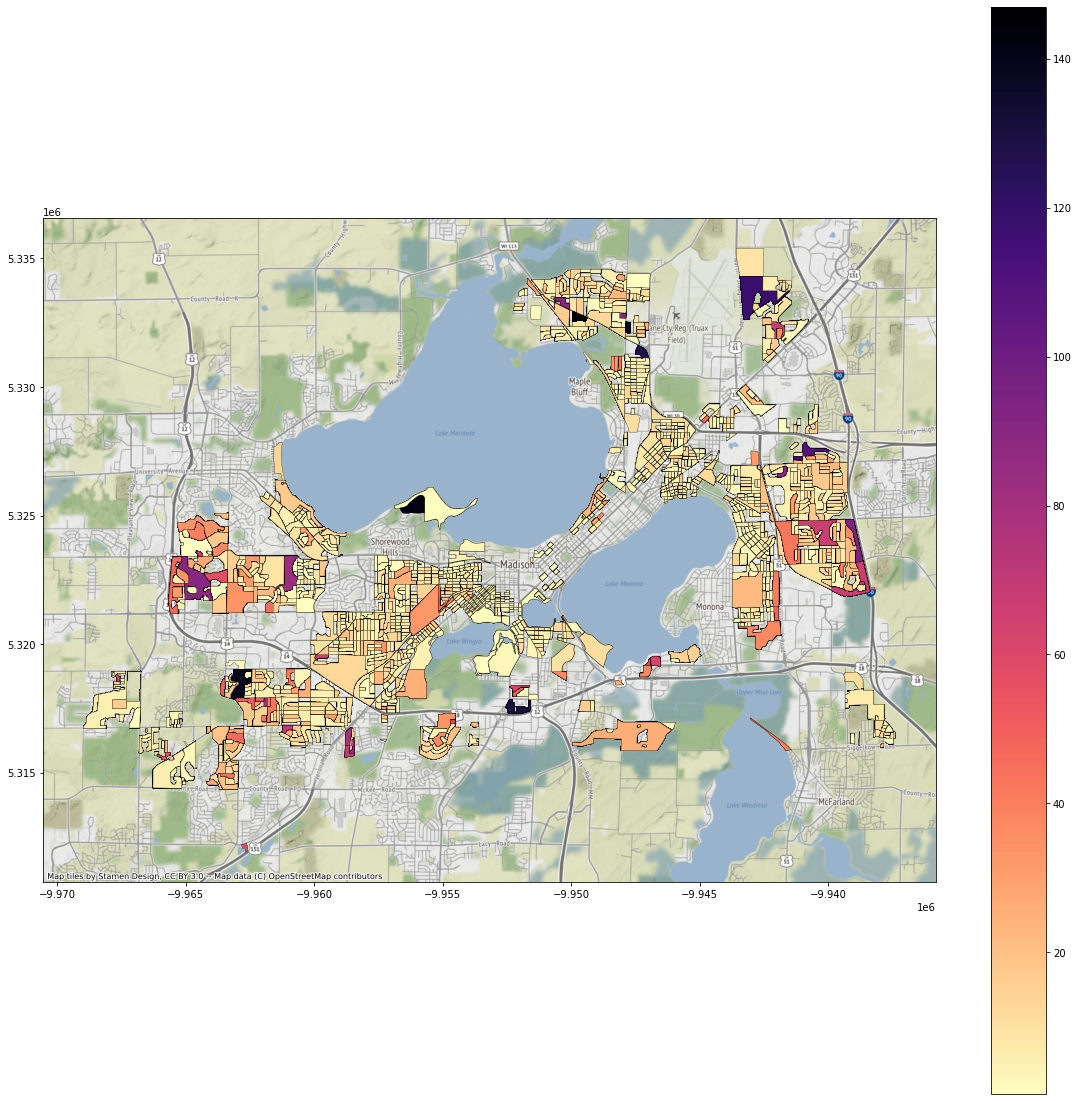

In [32]:
madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
madison = madison.to_crs(epsg=3857)
ax = madison.plot(figsize=(20,20), edgecolor='black', linewidth=0.3, column='Total_K-12_block', cmap='magma_r', k=50, legend=True)
ctx.add_basemap(ax)

In [33]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [34]:
# select out Points with no less than 15 K-12 children.
above_15_point = point_order[point_order['K-12_by_point'] >= 15]
above_15_point[['Address', 'PropertyUse', 'XCoord', 'YCoord', 'K12_est', 'K-12_by_point']].to_csv("Above_15_Point.csv", index=False)
above_15_point.head()


Area  \
37278  Block 1001, Block Group 1, Census Tract 32, Da...   
37512  Block 2012, Block Group 2, Census Tract 4.07, ...   
26973  Block 2008, Block Group 2, Census Tract 2.05, ...   
26906  Block 2008, Block Group 2, Census Tract 2.05, ...   
26911  Block 2008, Block Group 2, Census Tract 2.05, ...   

                    Address  PropertyUse  Bedrooms  \
37278  2701 Lake Mendota Dr       Vacant      0.01   
37512       957 S Gammon Rd       Vacant      0.01   
26973      7408 Old Sauk Rd  Condominium      3.01   
26906      7294 Old Sauk Rd  Condominium      2.01   
26911      7324 Old Sauk Rd  Condominium      2.01   

                         geometry         XCoord         YCoord  Total_people  \
37278  POINT (-89.43519 43.09015)  807538.501985  488460.986586          1353   
37512  POINT (-89.50338 43.04400)  789303.778668  471649.888130           283   
26973  POINT (-89.51222 43.07606)  786954.418390  483340.753717           299   
26906  POINT (-89.51222 43.07606)  786954.418390  483340.753717           299   
26911  POINT (-89.51222 43.07606)  786954.418390  483340.753717           299   

       Total_K-12_block                    GEO_ID  BlockBedrooms     K12_est  \
37278               142  1000000US550250032001001           0.01  142.000000   
37512                70  1000000US550250004072012           0.01   70.000000   
26973                68  1000000US550250002052008         298.29    0.686178   
26906                68  1000000US550250002052008         298.29    0.458212   
26911                68  1000000US550250002052008         298.29    0.458212   

       K-12_by_point  
37278          142.0  
37512           70.0  
26973           68.0  
26906           68.0  
26911           68.0

## Linear Regression part

In [54]:
Condominium_bedroom_block = merged[(merged["PropertyUse"] == "Condominium") | (merged["PropertyUse"] == "2 unit Apartment")
                                   | (merged["PropertyUse"] == "3 unit Apartment") | (merged["PropertyUse"] == "4 unit Apartment")
                                   | (merged["PropertyUse"] == "5 unit Apartment") | (merged["PropertyUse"] == "6 unit Apartment")
                                   | (merged["PropertyUse"] == "7 unit Apartment")]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

GEO_ID  BlockBedrooms  Total_K-12_block  \
0     1000000US550250006002003         141.73                79   
1     1000000US550250005012004           3.01                 2   
2     1000000US550250006003021           9.04                 2   
3     1000000US550250006002007          27.17                83   
4     1000000US550250014022008         116.30                37   
...                        ...            ...               ...   
1377  1000000US550250006002001          12.01                14   
1378  1000000US550250004072012           0.01                70   
1379  1000000US550250002052009          88.45                 7   
1380  1000000US550250109031015         213.83                 7   
1381  1000000US550250111013002           0.01                14   

                        geometry  Apartment_bedroom  other_bedroom  
0     POINT (-89.46093 43.02791)             141.72           0.01  
1     POINT (-89.46611 43.02981)               0.00           3.01  
2     POINT (-89.44750 43.02810)               0.00           9.04  
3     POINT (-89.45832 43.02627)               0.00          27.17  
4     POINT (-89.42949 43.02727)               0.00         116.30  
...                          ...                ...            ...  
1377  POINT (-89.45869 43.02920)              12.01           0.00  
1378  POINT (-89.50338 43.04400)               0.00           0.01  
1379  POINT (-89.50895 43.07613)              88.45           0.00  
1380  POINT (-89.53991 43.04147)             213.83           0.00  
1381  POINT (-89.48268 43.09456)               0.00           0.01  

[1382 rows x 6 columns]

Text(0.5, 1.0, 'Linear Regression Coefficients')

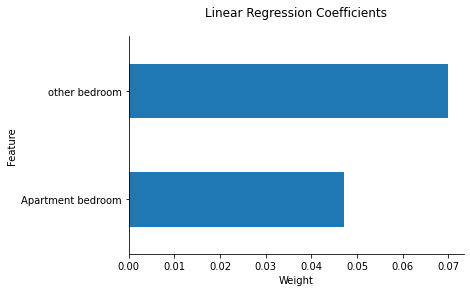

In [55]:
xcol = ["Apartment_bedroom", "other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
ax3 = pd.Series(model1["lr"].coef_, index=idx).plot.barh()
ax3.set_xlabel("Weight")
ax3.set_ylabel("Feature")
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.set_title("Linear Regression Coefficients", pad=20)

## Top 20 apartments table

In [56]:
Top_20 = K12_df
Top_20 = Top_20[(Top_20["PropertyUse"] == "Condominium") | (Top_20["PropertyUse"] == "2 unit Apartment")
                                   | (Top_20["PropertyUse"] == "3 unit Apartment") | (Top_20["PropertyUse"] == "4 unit Apartment")
                                   | (Top_20["PropertyUse"] == "5 unit Apartment") | (Top_20["PropertyUse"] == "6 unit Apartment")
                                   | (Top_20["PropertyUse"] == "7 unit Apartment")]
Top_20["Apartment_bedrooms"] = Top_20.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_20 = Top_20.drop_duplicates("geometry")
Top_20 = Top_20.sort_values(by=['K-12_by_point'], ascending=False)
Top_20 = Top_20[:20]
Top_20 = Top_20[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point"]]
Top_20.to_csv("Top20_Apartments.csv", index = False)


/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Plots

#### cumulative children live in apartments

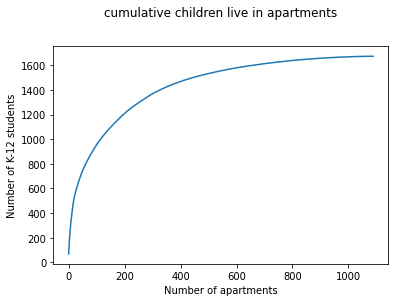

In [57]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[(Buildings["PropertyUse"] == "Condominium") | (Buildings["PropertyUse"] == "2 unit Apartment")
                                   | (Buildings["PropertyUse"] == "3 unit Apartment") | (Buildings["PropertyUse"] == "4 unit Apartment")
                                   | (Buildings["PropertyUse"] == "5 unit Apartment") | (Buildings["PropertyUse"] == "6 unit Apartment")
                                   | (Buildings["PropertyUse"] == "7 unit Apartment")]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
plt.plot(K12_data.cumsum())
plt.axis('tight')
plt.title("cumulative children live in apartments", pad=30)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
plt.show()



## Use the linear regression coef to improve the estimate


In [58]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["other_bedroom"] + result["Apartment_bedroom"]
                                                     * (apt_pro/house_pro)) * (result["Apartment_bedroom"]
                                                                               * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result

GEO_ID  BlockBedrooms  Total_K-12_block  \
0     1000000US550250006002003         141.73                79   
1     1000000US550250005012004           3.01                 2   
2     1000000US550250006003021           9.04                 2   
3     1000000US550250006002007          27.17                83   
4     1000000US550250014022008         116.30                37   
...                        ...            ...               ...   
1377  1000000US550250006002001          12.01                14   
1378  1000000US550250004072012           0.01                70   
1379  1000000US550250002052009          88.45                 7   
1380  1000000US550250109031015         213.83                 7   
1381  1000000US550250111013002           0.01                14   

                        geometry  Apartment_bedroom  other_bedroom  \
0     POINT (-89.46093 43.02791)             141.72           0.01   
1     POINT (-89.46611 43.02981)               0.00           3.01   
2     POINT (-89.44750 43.02810)               0.00           9.04   
3     POINT (-89.45832 43.02627)               0.00          27.17   
4     POINT (-89.42949 43.02727)               0.00         116.30   
...                          ...                ...            ...   
1377  POINT (-89.45869 43.02920)              12.01           0.00   
1378  POINT (-89.50338 43.04400)               0.00           0.01   
1379  POINT (-89.50895 43.07613)              88.45           0.00   
1380  POINT (-89.53991 43.04147)             213.83           0.00   
1381  POINT (-89.48268 43.09456)               0.00           0.01   

      K12_in_apt  K12_in_other  
0      78.991733      0.008267  
1       0.000000      2.000000  
2       0.000000      2.000000  
3       0.000000     83.000000  
4       0.000000     37.000000  
...          ...           ...  
1377   14.000000      0.000000  
1378    0.000000     70.000000  
1379    7.000000      0.000000  
1380    7.000000      0.000000  
1381    0.000000     14.000000  

[1382 rows x 8 columns]

### The density plot of k12 in apartment

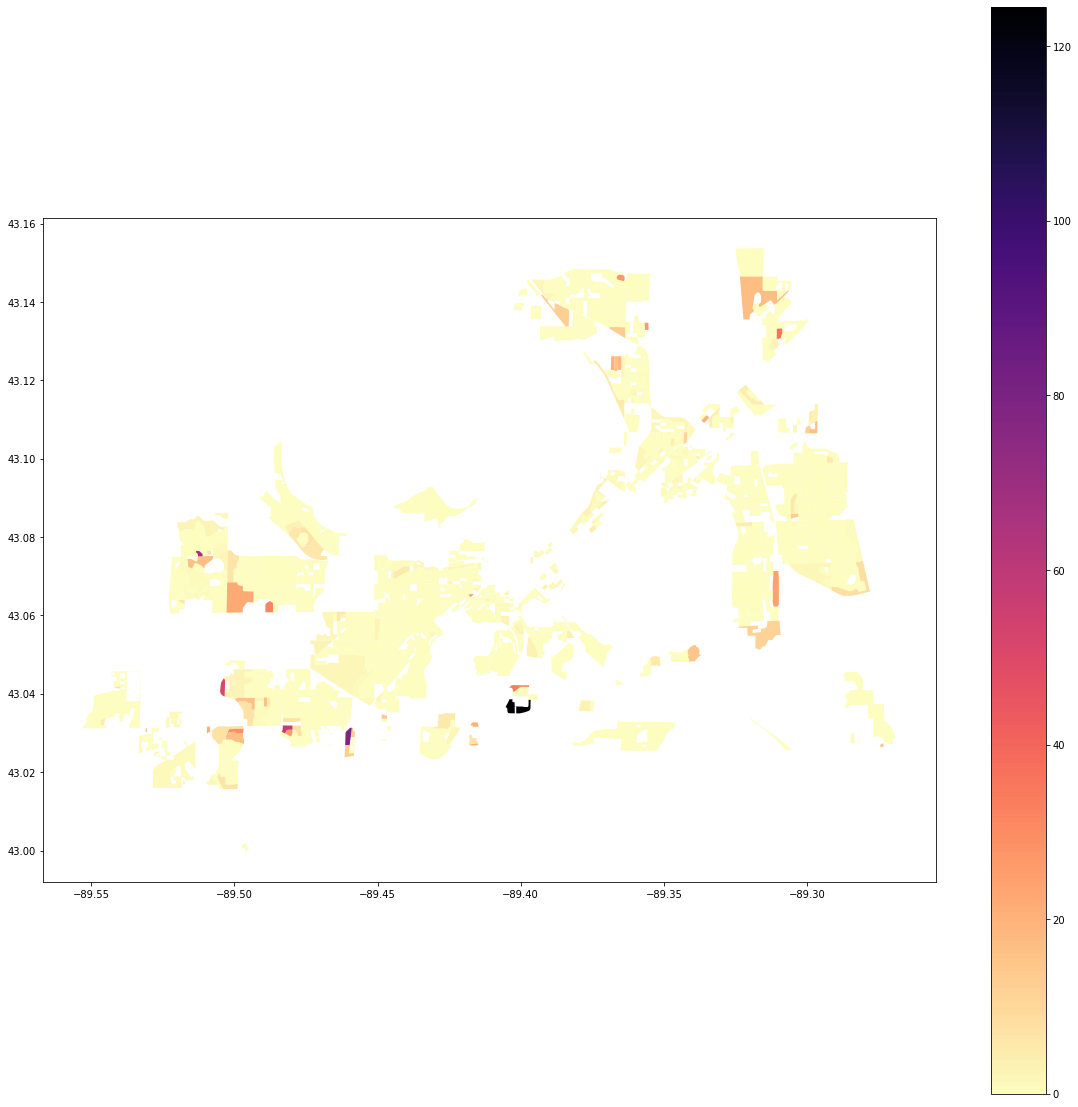

In [66]:
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
# apartment_madison = apartment_madison.to_crs(epsg=3857)
ax = apartment_madison.plot(figsize=(20,20), column='K12_in_apt', cmap='magma_r', k=50, legend=True)
# ctx.add_basemap(ax)

### The density plot of k12 in other house

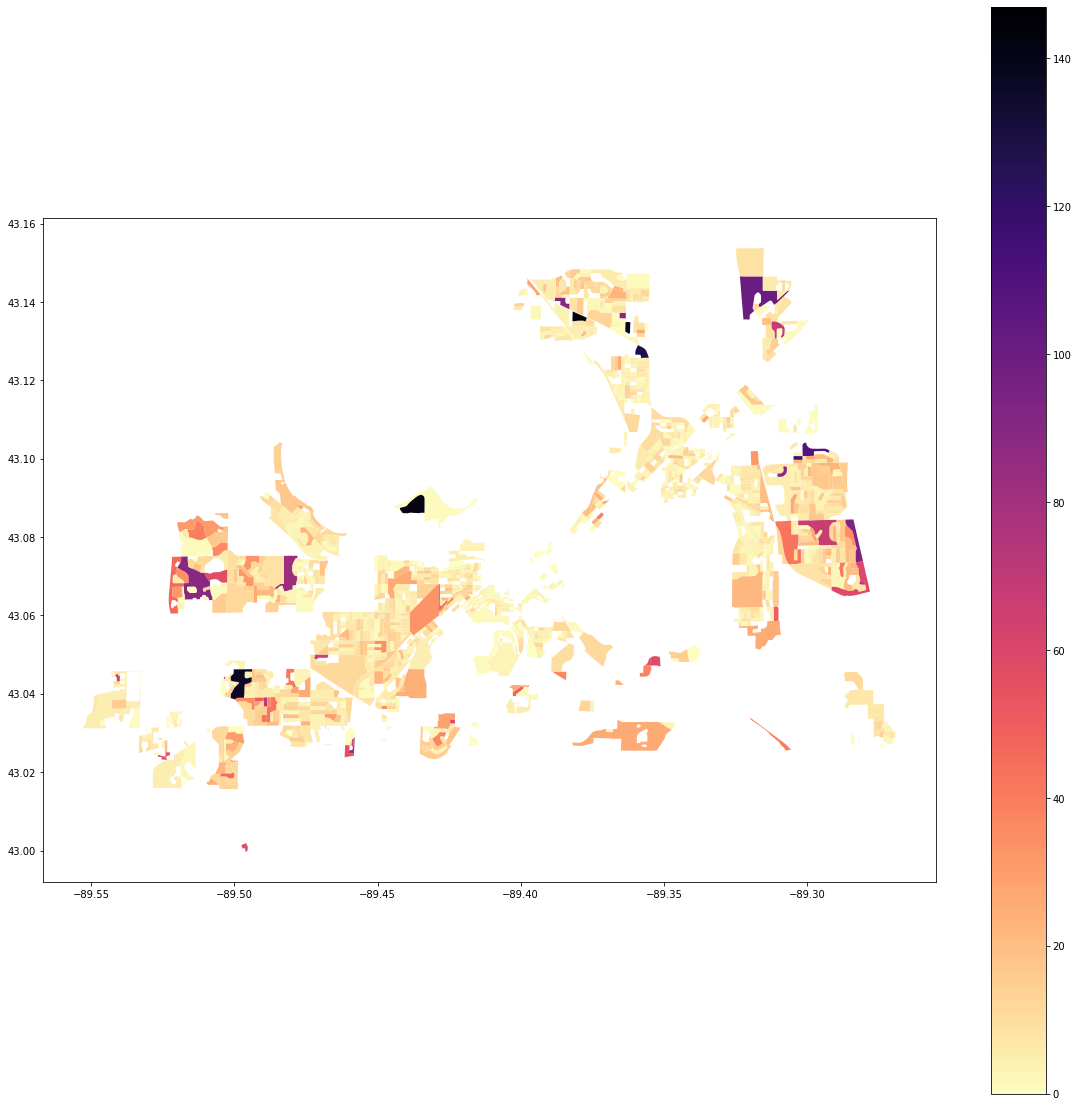

In [67]:
result = gpd.GeoDataFrame(result)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
# apartment_madison = apartment_madison.to_crs(epsg=3857)
ax = apartment_madison.plot(figsize=(20,20), column='K12_in_other', cmap='magma_r', k=50, legend=True)
# ctx.add_basemap(ax)

## Properties That May Have K-12 Kids (by estimation)

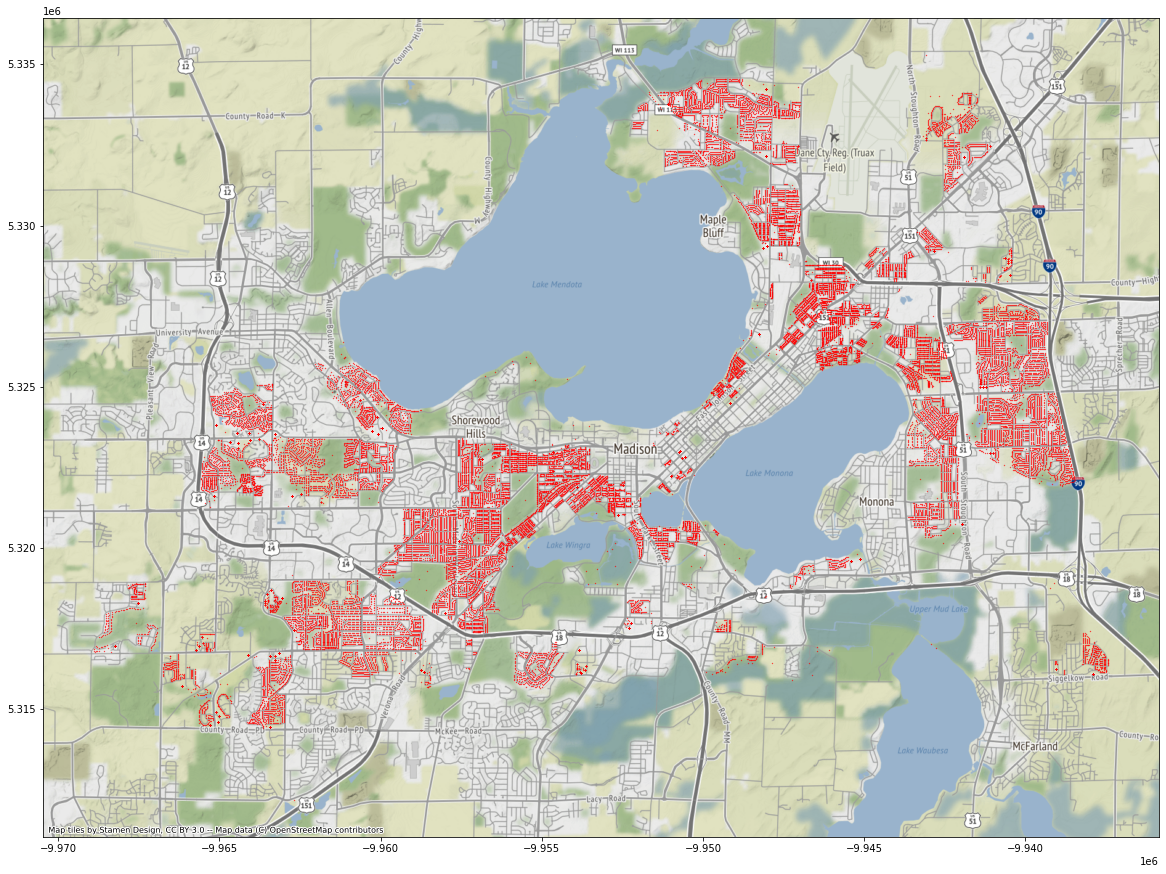

In [40]:
K12_df = K12_df.to_crs(epsg=3857)
ax_k12 = K12_df.plot(markersize=0.1, figsize=(20,20), color="red")
ax2 = ctx.add_basemap(ax_k12)

## Makersize Represented by the Number of K-12 Kids (by estimation)

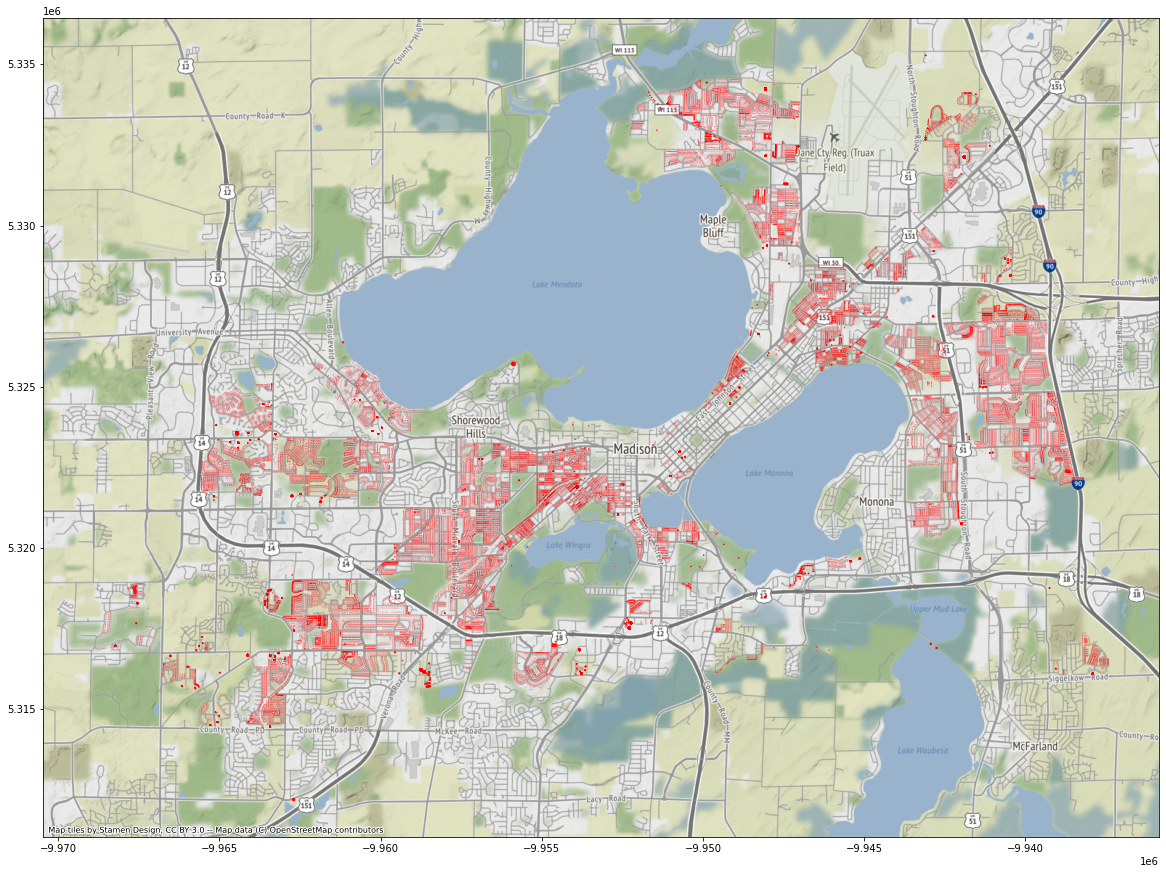

In [41]:
ax_k12_with_size = K12_df.plot(markersize=K12_df["K-12_by_point"]/10, figsize=(20,20), color="red")
ax3 = ctx.add_basemap(ax_k12_with_size)

## All Residential Properties in City of Madison

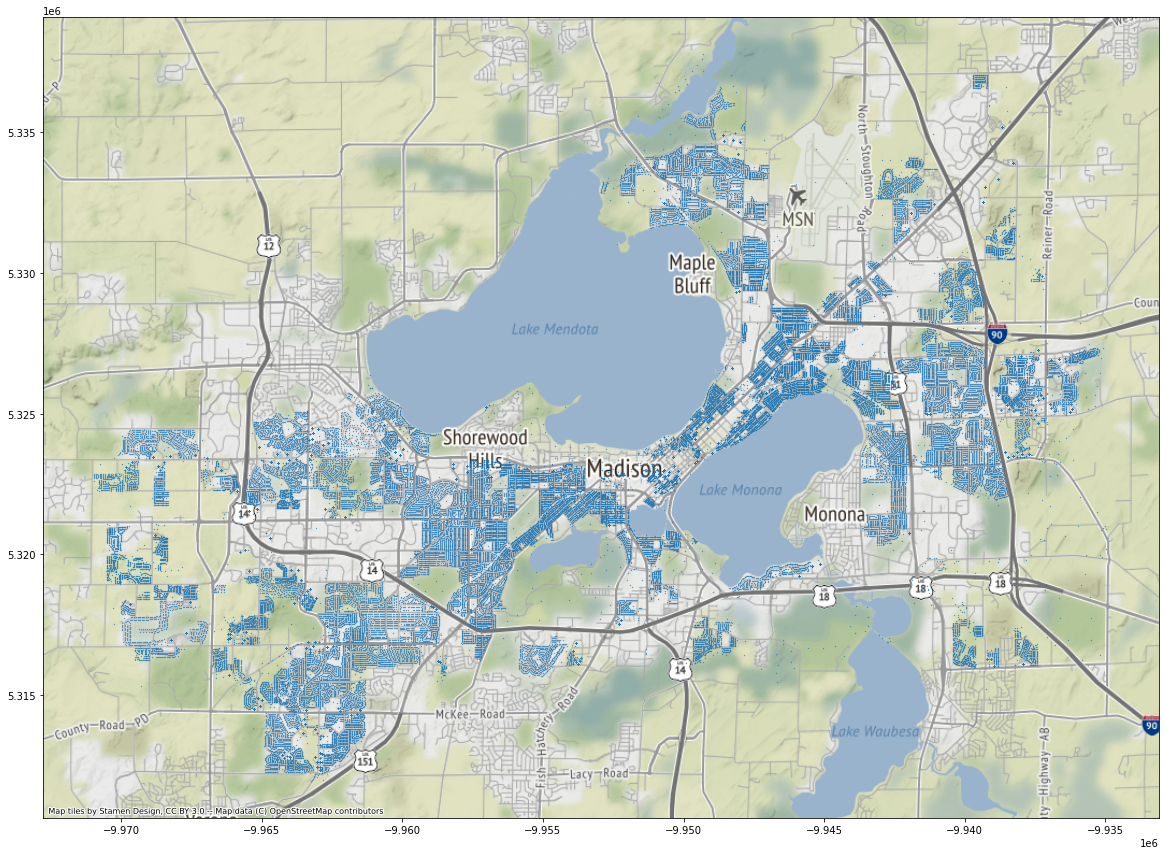

In [42]:
df = df.to_crs(epsg=3857)
ax = df.plot(markersize=0.1, figsize=(20,20))

ctx.add_basemap(ax)

STATEFP20 COUNTYFP20 TRACTCE20 BLOCKCE20          GEOID20      NAME20  \
0            55        025    002900      2006  550250029002006  Block 2006   
1            55        025    012700      1050  550250127001050  Block 1050   
2            55        025    011404      4001  550250114044001  Block 4001   
3            55        025    000504      3015  550250005043015  Block 3015   
4            55        025    001200      4020  550250012004020  Block 4020   
...         ...        ...       ...       ...              ...         ...   
10956        55        025    001404      1028  550250014041028  Block 1028   
10957        55        025    013700      3015  550250137003015  Block 3015   
10958        55        025    012600      2052  550250126002052  Block 2052   
10959        55        025    012002      3007  550250120023007  Block 3007   
10960        55        025    010504      1028  550250105041028  Block 1028   

      MTFCC20  UR20 UACE20 UATYPE20 FUNCSTAT20  ALAND20  AWATER20  \
0       G5040  None   None     None          S    38858         0   
1       G5040  None   None     None          S  1055458         0   
2       G5040  None   None     None          S    47453         0   
3       G5040  None   None     None          S     8739         0   
4       G5040  None   None     None          S     7686         0   
...       ...   ...    ...      ...        ...      ...       ...   
10956   G5040  None   None     None          S    51544         0   
10957   G5040  None   None     None          S    25571         0   
10958   G5040  None   None     None          S  3853916      4197   
10959   G5040  None   None     None          S    99459         0   
10960   G5040  None   None     None          S    40121         0   

        INTPTLAT20    INTPTLON20  \
0      +43.0614916  -089.3182030   
1      +43.0221242  -089.8262570   
2      +43.1937131  -089.2948433   
3      +43.0307340  -089.5300742   
4      +43.0644947  -089.4064235   
...            ...           ...   
10956  +43.0204968  -089.4339540   
10957  +42.9859974  -089.5160098   
10958  +42.8937790  -089.5668055   
10959  +42.9604880  -089.2022266   
10960  +43.0130002  -089.3044964   

                                                geometry  \
0      POLYGON ((-89.31992 43.06209, -89.31823 43.062...   
1      POLYGON ((-89.83427 43.02107, -89.83427 43.021...   
2      POLYGON ((-89.29664 43.19458, -89.29664 43.194...   
3      POLYGON ((-89.53060 43.03119, -89.52971 43.031...   
4      POLYGON ((-89.40721 43.06476, -89.40698 43.064...   
...                                                  ...   
10956  POLYGON ((-89.43501 43.01975, -89.43497 43.020...   
10957  POLYGON ((-89.51631 42.98645, -89.51631 42.986...   
10958  POLYGON ((-89.58932 42.90823, -89.58856 42.908...   
10959  POLYGON ((-89.20359 42.96013, -89.20359 42.960...   
10960  POLYGON ((-89.30593 43.01296, -89.30588 43.013...   

                         GEO_ID  
0      1000000US550250029002006  
1      1000000US550250127001050  
2      1000000US550250114044001  
3      1000000US550250005043015  
4      1000000US550250012004020  
...                         ...  
10956  1000000US550250014041028  
10957  1000000US550250137003015  
10958  1000000US550250126002052  
10959  1000000US550250120023007  
10960  1000000US550250105041028  

[10961 rows x 17 columns]